# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn import tree, svm, linear_model, preprocessing
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split,\
                                                                StratifiedKFold
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.preprocessing import OneHotEncoder

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

35.013025438831974

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.979805897215666

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
X = np.random.exponential(size=sample_size)[:,np.newaxis]
y = f(X).reshape(100,)+np.random.uniform(low=-1, high=1,\
                                             size=sample_size).reshape(100,)
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)
cross_val_score(clf, X, y, cv=10)

array([ 0.11522883, -0.8054913 , -0.86702186, -0.88990316, -0.79204967,
        0.29600125, -3.05427722, -0.62003095, -4.41512786, -0.11928637])

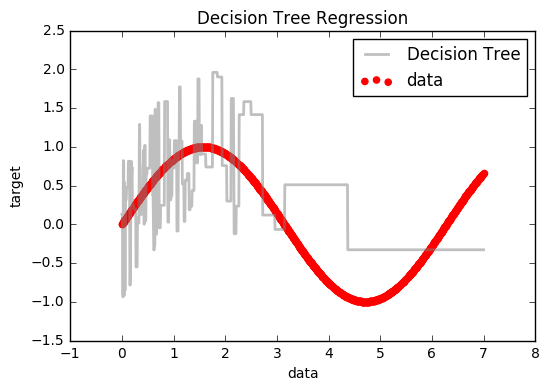

In [7]:
X_test = linspace[:, np.newaxis]
y_1=clf.predict(X_test)
plt.figure()
plt.scatter(linspace, f(linspace), s=20,
            color="red", label="data")
plt.plot(linspace, y_1, color="grey", alpha=0.5,
        label="Decision Tree", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

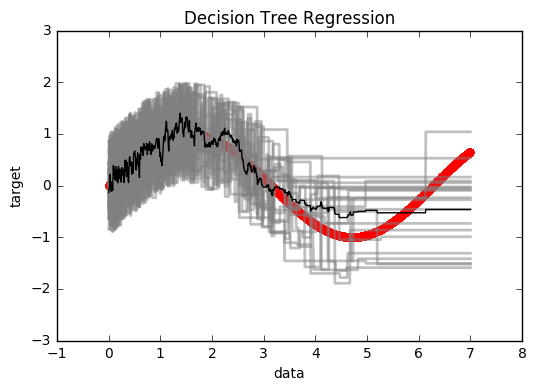

In [8]:
plt.figure()
y_list = []
for x in range(samples_num):
    X = np.random.exponential(size=sample_size)[:,np.newaxis]
    y = f(X).reshape(100,)+np.random.uniform(low=-1, high=1,\
                                                 size=sample_size).reshape(100,)
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(X, y)
    X_test = linspace[:, np.newaxis]
    y_1=clf.predict(X_test)
    y_list.append(y_1)
    #plt.plot(sum(y_list)/len(y_list),color='black')
    plt.scatter(linspace, f(linspace), s=20,
                color="red", label="data")
    plt.plot(linspace, y_1, color="grey", alpha=0.5,
            label="Decision Tree", linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
plt.plot(linspace, sum(y_list)/samples_num, color='black')

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

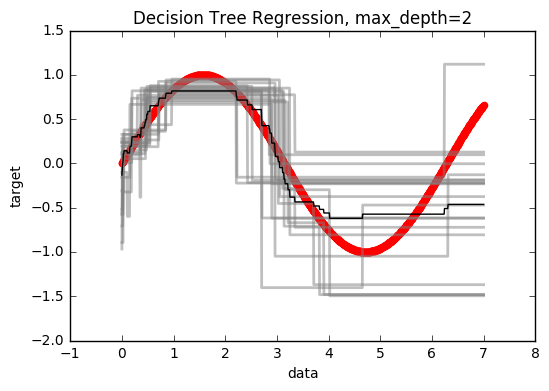

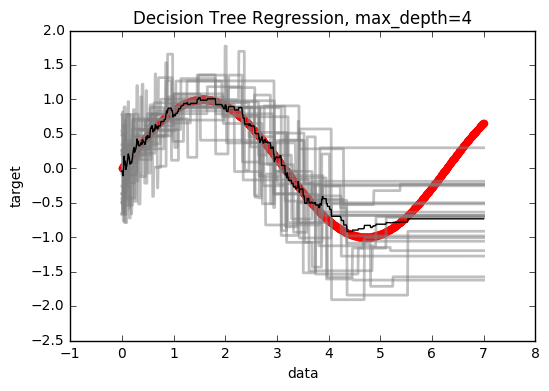

In [9]:
np.random.seed(5)
for max_depth in [2,4]:
    y_list = []
    plt.figure()
    plt.scatter(linspace, f(linspace), s=20,
                    color="red", label="data")
    for x in range(samples_num):
        X = np.random.exponential(size=sample_size)[:,np.newaxis]
        y = f(X).reshape(100,)+np.random.uniform(low=-1, high=1,\
                                                 size=sample_size).reshape(100,)
        clf = tree.DecisionTreeRegressor(max_depth=max_depth)
        clf = clf.fit(X, y)
        X_test = linspace[:, np.newaxis]
        y_1=clf.predict(X_test)
        y_list.append(y_1)
        plt.plot(linspace, y_1, color="grey", alpha=0.5,
                label="Decision Tree", linewidth=2)
        plt.xlabel("data")
        plt.ylabel("target")
        plt.title("Decision Tree Regression"+', max_depth='+str(max_depth))
    plt.plot(linspace, sum(y_list)/samples_num, color='black')

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

#### Для дерева без ограничения мы видим самое большое смещение результата. При увеличении глубины дерева мы видим, что смещение уменьшается, однако, утверждать, что оно близко к 0 мы не можем, так как видим, что происходит расхождение значений

(・・ ) ?



__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

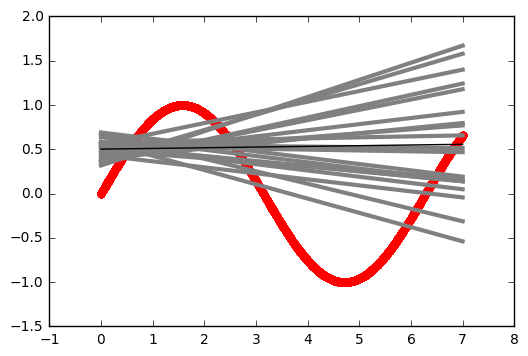

In [10]:
y_list = []
plt.figure()
plt.scatter(linspace, f(linspace), s=20,
                    color="red", label="data")
for x in range(samples_num):
    X = np.random.exponential(size=sample_size)[:,np.newaxis]
    y = f(X).reshape(100,)+np.random.uniform(low=-1, high=1,\
                                                 size=sample_size).reshape(100,)
    X_test = linspace[:, np.newaxis]
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    y_1 = regr.predict(X_test)
    y_list.append(y_1)
    plt.scatter(linspace, f(linspace),  color='red')
    plt.plot(linspace, y_1, color='grey', linewidth=3)
plt.plot(linspace, sum(y_list)/samples_num, color='black')

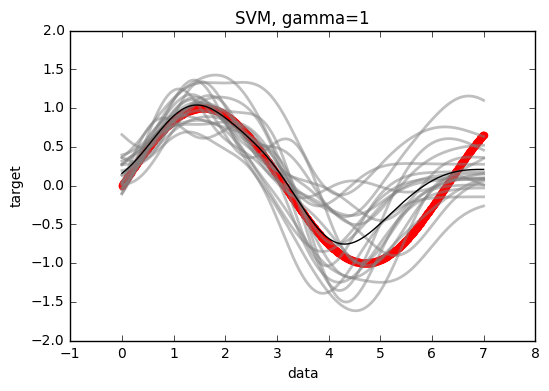

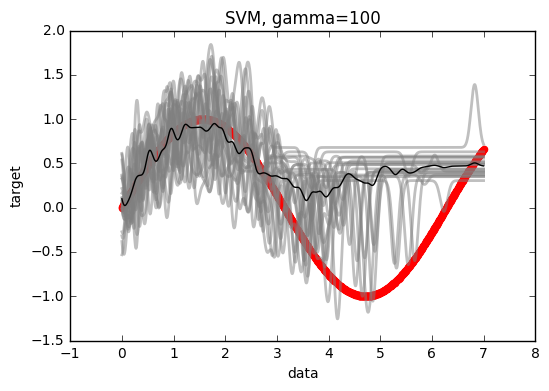

In [11]:
for gamma in [1,100]:
    y_list = []
    plt.figure()
    plt.scatter(linspace, f(linspace), s=20,
                    color="red", label="data")
    for x in range(samples_num):
        X = np.random.exponential(size=sample_size)[:,np.newaxis]
        y = f(X).reshape(100,)+np.random.uniform(low=-1, high=1,\
                                                 size=sample_size).reshape(100,)
        clf = SVR(kernel='rbf',gamma=gamma)
        clf = clf.fit(X, y)
        X_test = linspace[:, np.newaxis]
        y_1=clf.predict(X_test)
        y_list.append(y_1)
        plt.plot(linspace, y_1, color="grey", alpha=0.5,
                label="Decision Tree", linewidth=2)
        plt.xlabel("data")
        plt.ylabel("target")
        plt.title("SVM"+', gamma='+str(gamma))
    plt.plot(linspace, sum(y_list)/samples_num, color='black')

#### SVM дает меньшее смещение для gamma=1. Так как среднее не так сильно расходится с нашей функцией. Регрессия имеет положительный наклон, который неадекватно аппроксимирует нашу функцию, в силу устройства модели.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [4]:
url_mushroom = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
mushroom=pd.read_csv(url_mushroom)

url_tic_tac = "http://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data" 
tic_tac = pd.read_csv(url_tic_tac, header=None)

url_cars = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
cars = pd.read_csv(url_cars, header=None)

url_nursery = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
nursery = pd.read_csv(url_nursery, header=None)

In [5]:
def categorize(x):
    if x in ['unacc','acc','not_recom','recommend']:
        return 0
    elif x in ['good','vgood',"very_recom", "priority", "spec_prior"]:
        return 1

le = preprocessing.LabelEncoder()
for data in [mushroom, tic_tac]:
    for i in range(data.shape[1]):
        le.fit(data.iloc[:,i])
        data.iloc[:,i] = le.transform(data.iloc[:,i])
for data in [cars, nursery]:
    data.iloc[:,-1] = data.iloc[:,-1].apply(categorize)
    for i in range(data.shape[1]):
        le.fit(data.iloc[:,i])
        data.iloc[:,i] = le.transform(data.iloc[:,i])


In [6]:
for data in [mushroom]: 
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    print(np.mean(cross_val_score(X=X, y=y,\
              estimator=DecisionTreeClassifier(),\
                              cv=10, scoring=make_scorer(accuracy_score))))
for data in [tic_tac, cars, nursery]:
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    print(np.mean(cross_val_score(X=X, y=y,\
              estimator=DecisionTreeClassifier(),\
                          cv=10, scoring=make_scorer(accuracy_score))))

0.957537275743
0.740990911557
0.940390269981
0.999691477008


In [38]:
mushroom_dummy = pd.get_dummies(mushroom)
tic_tac_dummy = pd.get_dummies(tic_tac)
cars_dummy = pd.get_dummies(cars)
nursery_dummy = pd.get_dummies(nursery)

for data in [mushroom_dummy]: 
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    print(np.mean(cross_val_score(X=X, y=y,\
              estimator=DecisionTreeClassifier(),\
                              cv=10, scoring=make_scorer(accuracy_score))))
for data in [tic_tac_dummy, cars_dummy, nursery_dummy]:
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    print(np.mean(cross_val_score(X=X, y=y,\
              estimator=DecisionTreeClassifier(),\
                          cv=10, scoring=make_scorer(accuracy_score))))

0.962716067358
0.743074470971
1.0
1.0


#### Мы видим, что для всех категориальных признаков качество улучшается по всем выборкам, кроме tic_tac_toe датасета.

In [8]:
def categorize_cols(df, x, y):
    for i in range(len(df)):
        if df.iloc[i,2] in ['5more','more']:
            df[x][i]=1
            df[y][i]=0
        else:
            df[x][i]=0

cars['d']=cars.iloc[:,2]
cars['dm']=cars['d']
cars['p']=cars.iloc[:,3]
cars['pm']=cars['p']
categorize_cols(cars,'dm','d')
categorize_cols(cars,'pm','p')
cars["d"]=cars['d'].astype('float32')
cars["p"]=cars['p'].astype('float32')

cars_1 = pd.get_dummies(cars.iloc[:,:2])
cars_2 = pd.get_dummies(cars.iloc[:,4:6])
cars_un = pd.concat([cars_1,cars_2, cars['d'],cars['dm'],\
                             cars['p'],cars['pm']],axis=1)

In [34]:
def categorize_cols(df, x, y):
    for i in range(len(df)):
        if df.iloc[i,2] =='more':
            df[x][i]=1
            df[y][i]=0
        else:
            df[x][i]=0

nursery['c']=nursery.iloc[:,3]
nursery['cm']=nursery['c']
categorize_cols(nursery,'cm','c')
nursery["c"]=nursery['c'].astype('float64')

nursery_1 = pd.get_dummies(cars.iloc[:,:3])
nursery_2 = pd.get_dummies(cars.iloc[:,4:8])
nursery_un = pd.concat([nursery_1,nursery_2, nursery['c'],\
                                    nursery['cm']],axis=1)
nursery_un=nursery_un.dropna()

In [35]:
for data in [mushroom_dummy]: 
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    print(np.mean(cross_val_score(X=X, y=y,\
              estimator=DecisionTreeClassifier(),\
                              cv=10, scoring=make_scorer(accuracy_score))))
for data in [tic_tac, cars_un, nursery_un]:
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    print(np.mean(cross_val_score(X=X, y=y,\
              estimator=DecisionTreeClassifier(),\
                          cv=10, scoring=make_scorer(accuracy_score))))

0.958277103116
0.762456931633
1.0
1.0


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

#### Мы видим, что результат, в зависимости от добавление вещественных признаков, сильно не изменил полученные значения. В результатах присутствует компонента случайности, которую дает наш классификатор. 

(・・ ) ?


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [133]:
wineq = pd.read_csv('winequality-red.csv',sep=';')
X = wineq.iloc[:,:-1]
y = wineq.iloc[:,-1]
cv = StratifiedKFold(n_splits=3, shuffle=True)
for clf in [DecisionTreeClassifier(),
            BaggingClassifier(n_estimators=100),
            BaggingClassifier(n_estimators=100, max_features=0.5),
            RandomForestClassifier(n_estimators=100)]:
    print(np.mean(cross_val_score(X=X, y=y,estimator=clf,\
                              cv=cv, scoring=make_scorer(accuracy_score))))

0.603451626616
0.667368816706
0.679761777119
0.674821897008


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

#### Мы видим по графику, что качество растет до стабильного значения, после этого качество выходит на устойчивую траекторию и меняется согласно некоторому шуму, поэтому модель не переобучается

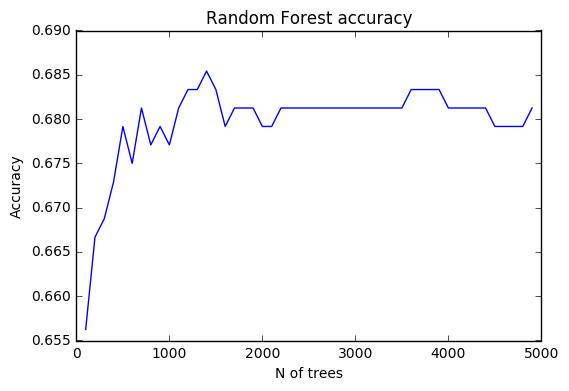

In [161]:
from sklearn.utils import shuffle
wineq_shuffled = shuffle(wineq)
X = wineq_shuffled.iloc[:,:-1]
y = wineq_shuffled.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.3, random_state=42)
numbers = np.arange(100, 5000, 100)
clf = RandomForestClassifier(warm_start=True)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

accuracy = []
for number in numbers:
    changed = clf.set_params(n_estimators=number)
    fit_changed = changed.fit(X_train, y_train)
    pred_changed = changed.predict(X_test)
    accuracy.append(accuracy_score(y_test,pred_changed))
plt.plot(numbers, accuracy)
plt.xlabel("N of trees")
plt.ylabel("Accuracy")
plt.title("Random Forest accuracy")

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, \
                                            Convolution2D, MaxPooling2D,Conv2D
from keras.utils import np_utils
from keras import backend
import tensorflow
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

(60000, 28, 28)


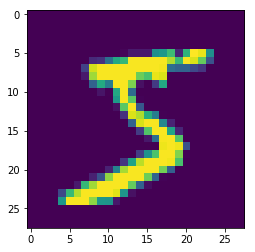

In [20]:
print(x_train.shape)
plt.imshow(x_train[0])

In [21]:
img_rows, img_cols = 28, 28

if backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [22]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [23]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [8]:
model = Sequential()
model.add(Dense(512, activation='relu',input_shape=input_shape))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [9]:
from keras.callbacks import EarlyStopping
earlystopping= EarlyStopping(monitor = 'val_loss',
min_delta=0,
patience = 1,
verbose=0, mode='auto')

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy, \
          optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [21]:
model.fit(x_train, y_train,batch_size=175,epochs=12,verbose=1,\
          validation_data=(x_test, y_test),callbacks = [earlystopping])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7641s 127ms/step - loss: 0.3609 - acc: 0.8904 - val_loss: 0.1813 - val_acc: 0.9437
Epoch 2/12
60000/60000 [==============================] - 1422s 24ms/step - loss: 0.1538 - acc: 0.9541 - val_loss: 0.1267 - val_acc: 0.9602
Epoch 3/12
60000/60000 [==============================] - 7336s 122ms/step - loss: 0.1085 - acc: 0.9676 - val_loss: 0.1009 - val_acc: 0.9686
Epoch 4/12
60000/60000 [==============================] - 7059s 118ms/step - loss: 0.0844 - acc: 0.9743 - val_loss: 0.1032 - val_acc: 0.9658
Test loss: 0.103230680651
Test accuracy: 0.9658


#### Нам удается добиться качества в 96% accuracy

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

model.fit(x_train, y_train,batch_size=128,epochs=12,verbose=1,validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 244s 4ms/step - loss: 0.2477 - acc: 0.9264 - val_loss: 0.0631 - val_acc: 0.9805
Epoch 2/12
60000/60000 [==============================] - 237s 4ms/step - loss: 0.0600 - acc: 0.9817 - val_loss: 0.0450 - val_acc: 0.9852
Epoch 3/12
60000/60000 [==============================] - 241s 4ms/step - loss: 0.0403 - acc: 0.9878 - val_loss: 0.0376 - val_acc: 0.9873
Epoch 4/12
60000/60000 [==============================] - 245s 4ms/step - loss: 0.0300 - acc: 0.9910 - val_loss: 0.0345 - val_acc: 0.9886
Epoch 5/12
60000/60000 [==============================] - 246s 4ms/step - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0343 - val_acc: 0.9892
Epoch 6/12
60000/60000 [==============================] - 248s 4ms/step - loss: 0.0173 - acc: 0.9952 - val_loss: 0.0387 - val_acc: 0.9877
Epoch 7/12
60000/60000 [==============================] - 238s 4ms/step - loss: 0.0136 - acc: 0.9961 - val_loss: 0.0300 - 

#### Мы добились качесва выше 99% на 9 эпохе из 12, после этого модель начинает переобучаться и качество падает

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [25]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

model.fit(x_train, y_train,batch_size=128,epochs=12,verbose=1,validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 256s 4ms/step - loss: 0.3371 - acc: 0.8977 - val_loss: 0.0787 - val_acc: 0.9757
Epoch 2/12
60000/60000 [==============================] - 252s 4ms/step - loss: 0.1118 - acc: 0.9667 - val_loss: 0.0541 - val_acc: 0.9837
Epoch 3/12
60000/60000 [==============================] - 269s 4ms/step - loss: 0.0848 - acc: 0.9749 - val_loss: 0.0458 - val_acc: 0.9845
Epoch 4/12
60000/60000 [==============================] - 250s 4ms/step - loss: 0.0720 - acc: 0.9785 - val_loss: 0.0362 - val_acc: 0.9873
Epoch 5/12
60000/60000 [==============================] - 247s 4ms/step - loss: 0.0636 - acc: 0.9805 - val_loss: 0.0350 - val_acc: 0.9881
Epoch 6/12
60000/60000 [==============================] - 262s 4ms/step - loss: 0.0565 - acc: 0.9834 - val_loss: 0.0360 - val_acc: 0.9874
Epoch 7/12
60000/60000 [==============================] - 250s 4ms/step - loss: 0.0498 - acc: 0.9854 - val_loss: 0.0323 - 

#### Нам удалось добиться большего качества по всей модели, итоговый результат - 99.14%, в отличие от предыдущего (99.02%)